In [200]:
deps <- c("ISLR", "Metrics", "tidyr", "microbenchmark", "dplyr", "gridExtra", "readxl", "cvTools", "leaps", "assertthat", "assertr", "testthat", "lubridate", "ggplot2", "stringr", "scales", "viridis")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}

options(scipen=999)
set.seed(42)

In [201]:
df <- read.csv("../data/data.csv", header = TRUE, sep = ",")

for (i in 1:ncol(df)) {
    cat(colnames(df)[i], "\n")
    cat("\ttype: ", class(df[,i]), "\n")
    cat("\tmissing: ", sum(is.na(df[,i])), "\n")
    cat("\tunique: ", length(unique(df[,i])), "\n")
    topfreq <- sort(table(df[,i]), decreasing = TRUE)[1:5]
    cat("\ttop 5 values:", names(topfreq), "\n")
}

rating 
	type:  numeric 
	missing:  1 
	unique:  6 
	top 5 values: 5 4 3 1 2 
title 
	type:  character 
	missing:  0 
	unique:  2938 
	top 5 values: Five Stars Four Stars Great Nice Good 
text 
	type:  character 
	missing:  0 
	unique:  3357 
	top 5 values: Great As expected Cool Good product I hate to &#34;review&#34; movies cause it's subjective... so honestly, I just like this movie.  If you like the actors in this film, you'll probably like this movie. 
timestamp 
	type:  character 
	missing:  0 
	unique:  3400 
	top 5 values:  2000-03-16 13:38:28.000 2000-06-11 23:08:16.000 2000-07-14 14:29:30.000 2000-07-19 14:40:40.000 
helpful_vote 
	type:  numeric 
	missing:  1 
	unique:  51 
	top 5 values: 0 1 2 3 4 
verified_purchase 
	type:  character 
	missing:  0 
	unique:  3 
	top 5 values: True False  NA NA 
category 
	type:  character 
	missing:  0 
	unique:  35 
	top 5 values: All_Beauty Amazon_Fashion Appliances Arts_Crafts_and_Sewing Automotive 
language 
	type:  character 
	missing

# (RQ1) Are reviews for some categories of product on Amazon overall more positive than for other categories?

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


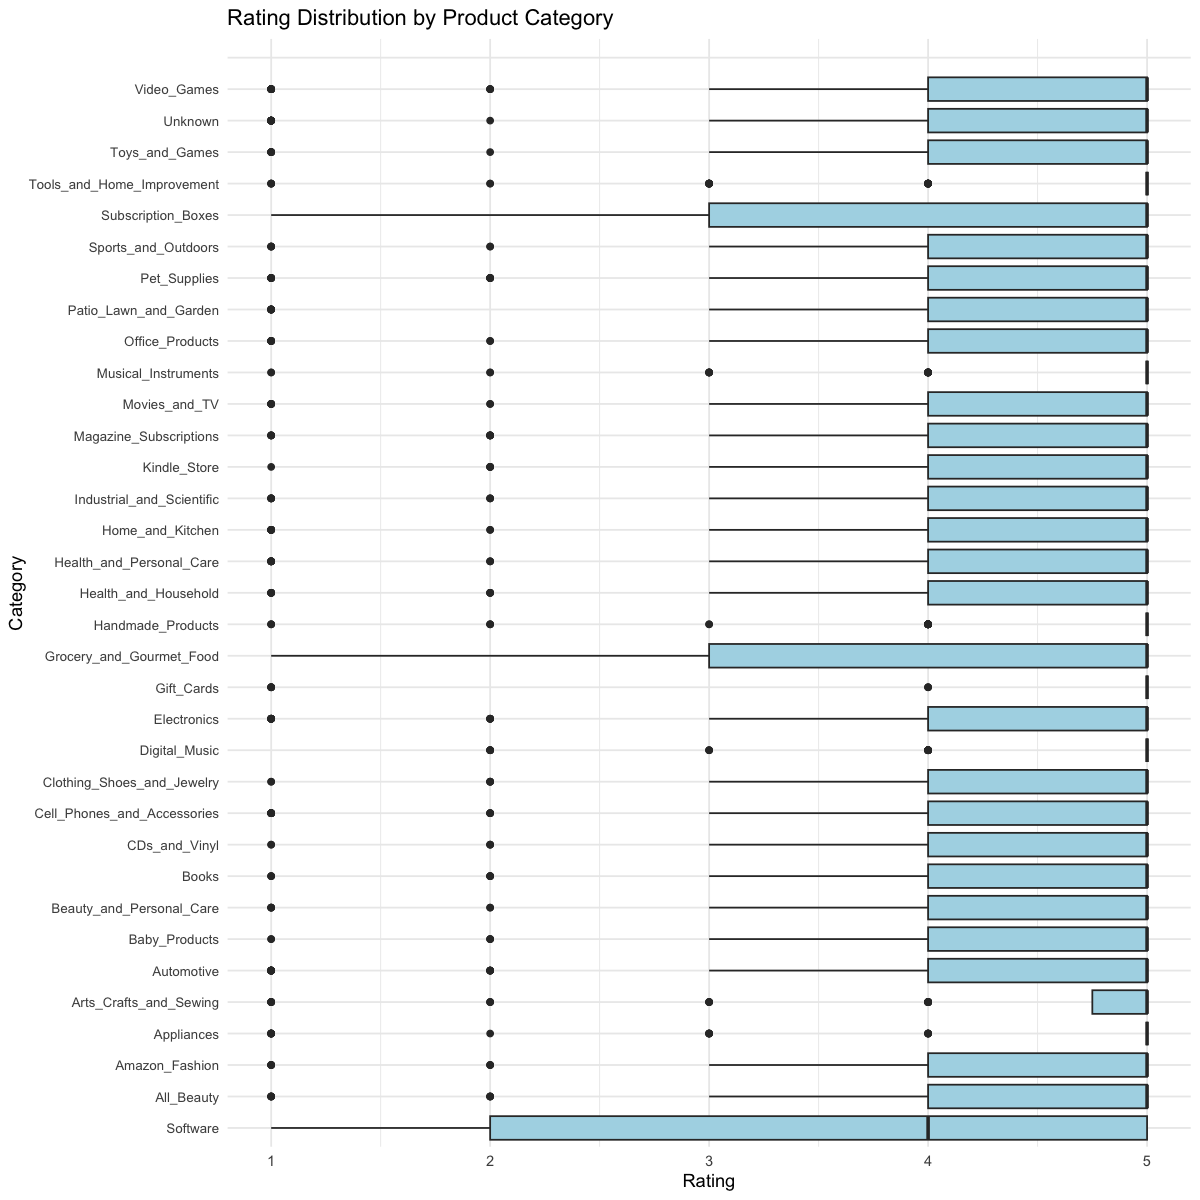

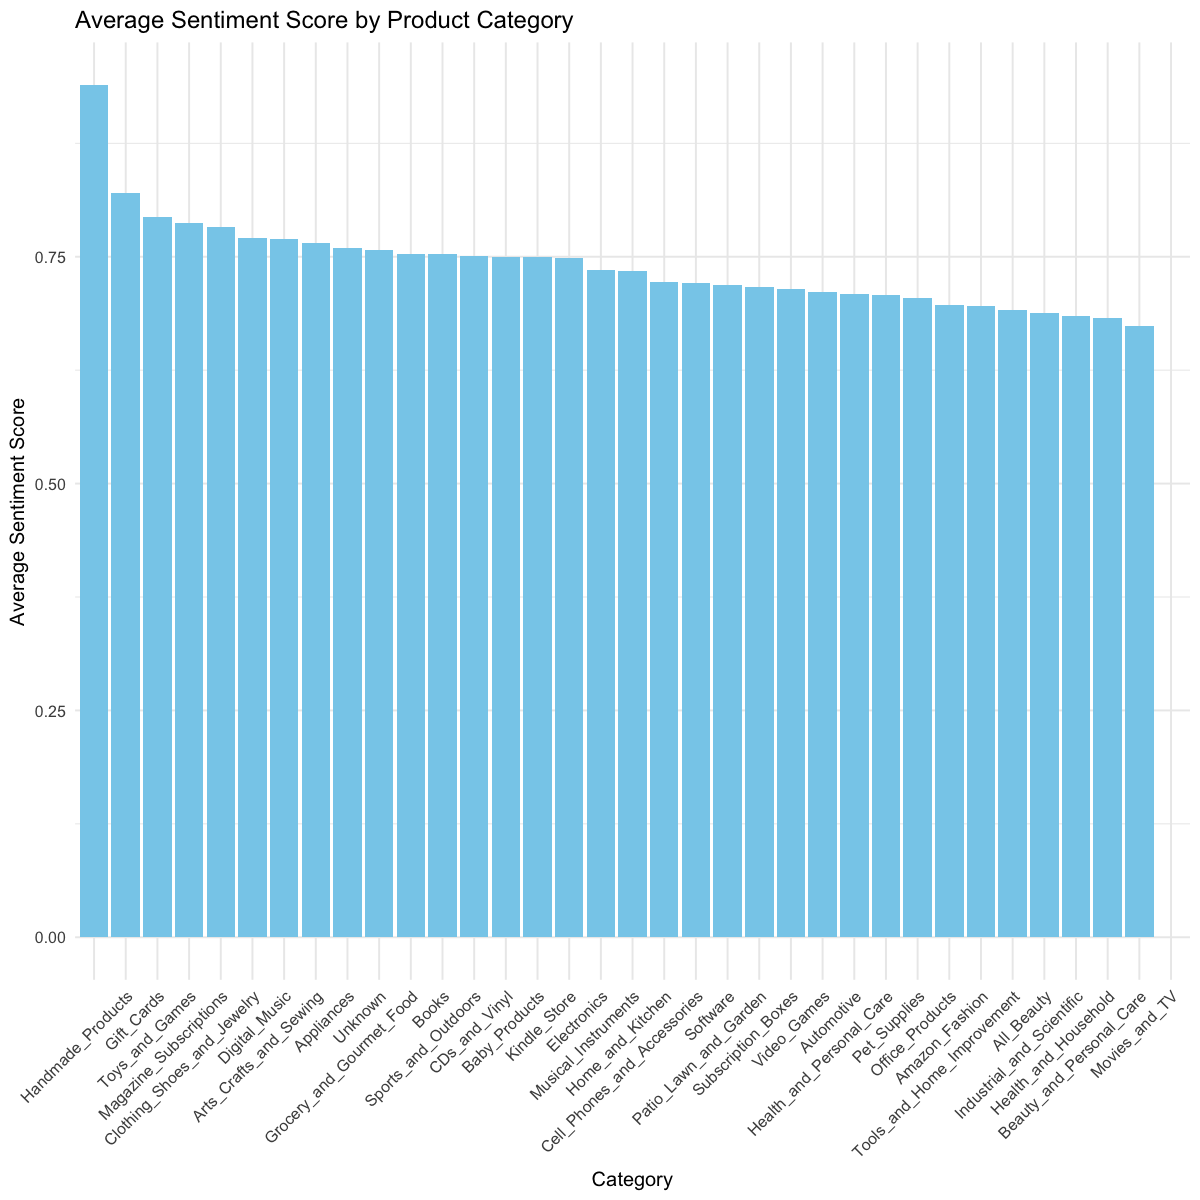

In [203]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(df, aes(x = reorder(category, rating, median), y = rating)) +
    geom_boxplot(fill = "lightblue") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Rating Distribution by Product Category", x = "Category", y = "Rating") +
    theme(axis.text.y = element_text(size = 8))

avg_sentiment <- aggregate(df$sentiment_score, by = list(Category = df$category), FUN = mean)
ggplot(avg_sentiment, aes(x = reorder(Category, -x), y = x)) + 
    geom_bar(stat = 'identity', fill = 'skyblue') + 
    labs(title = 'Average Sentiment Score by Product Category', x = 'Category', y = 'Average Sentiment Score') +       
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

# (RQ2) Are reviews more subjective for some classes of products than for others?

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”


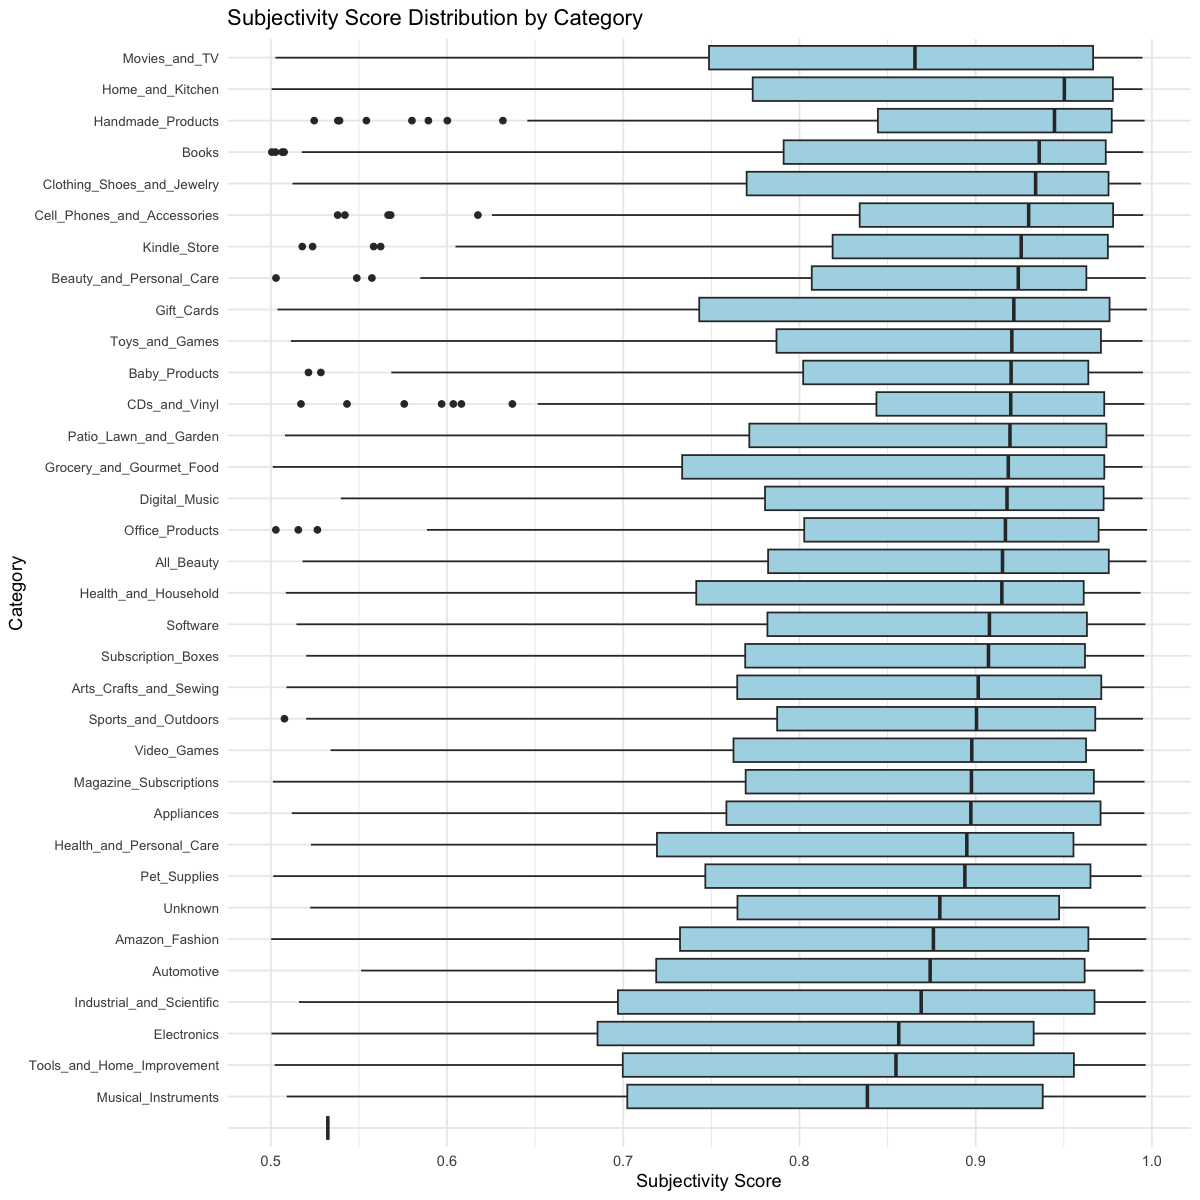

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


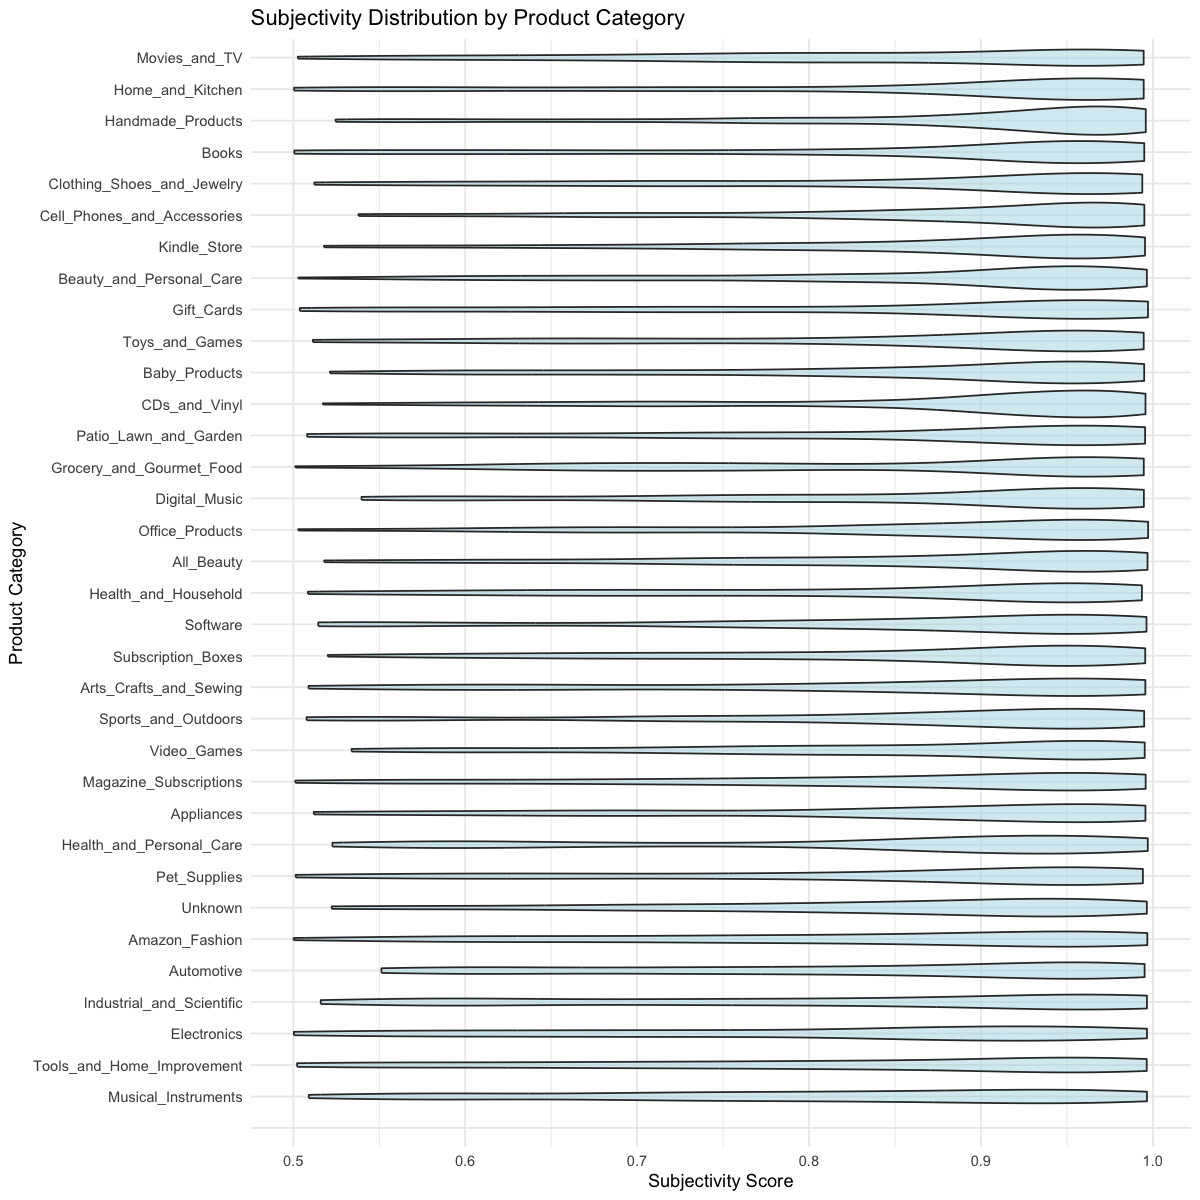

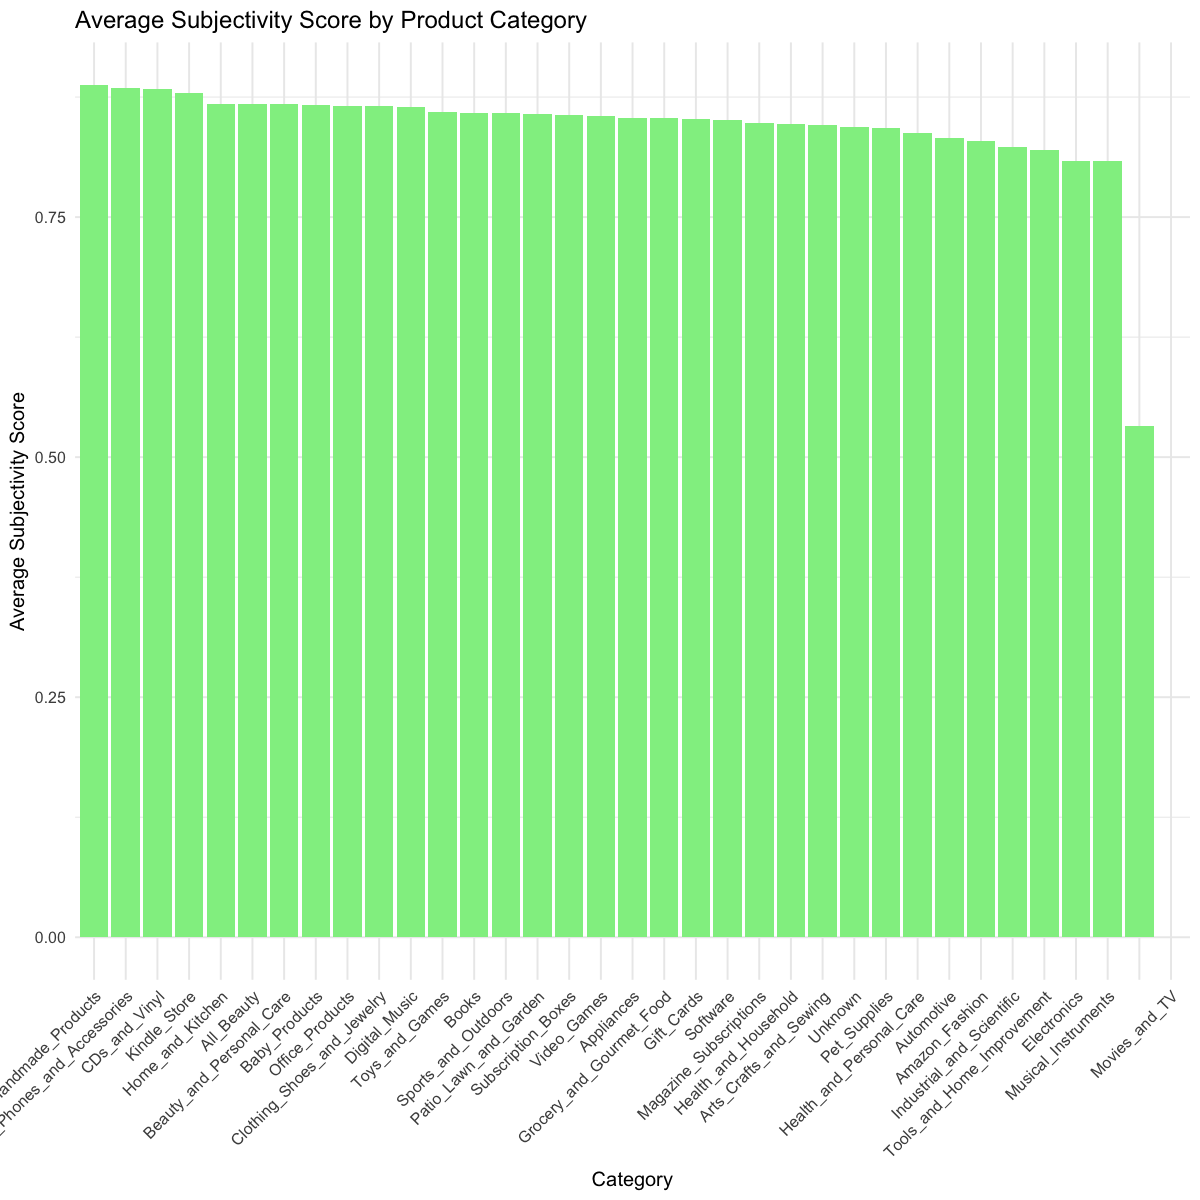

In [204]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(df, aes(x = reorder(category, subjectivity_score, median), y = subjectivity_score)) +
    geom_boxplot(fill = "lightblue") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Subjectivity Score Distribution by Category", x = "Category", y = "Subjectivity Score") +
    theme(axis.text.y = element_text(size = 8))

ggplot(df, aes(x = reorder(category, subjectivity_score, median), y = subjectivity_score)) +
    geom_violin(fill = "lightblue", alpha = 0.5) +
    coord_flip() +
    theme_minimal() +
    labs(x = "Product Category", y = "Subjectivity Score", title = "Subjectivity Distribution by Product Category")

avg_subjectivity <- aggregate(df$subjectivity_score, by = list(Category = df$category), FUN = mean)
ggplot(avg_subjectivity, aes(x = reorder(Category, -x), y = x)) + 
  geom_bar(stat = 'identity', fill = 'lightgreen') + 
  labs(title = 'Average Subjectivity Score by Product Category', 
       x = 'Category', 
       y = 'Average Subjectivity Score') + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# (RQ3) Which aspects of different classes of products are the most important in the reviews?


`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.


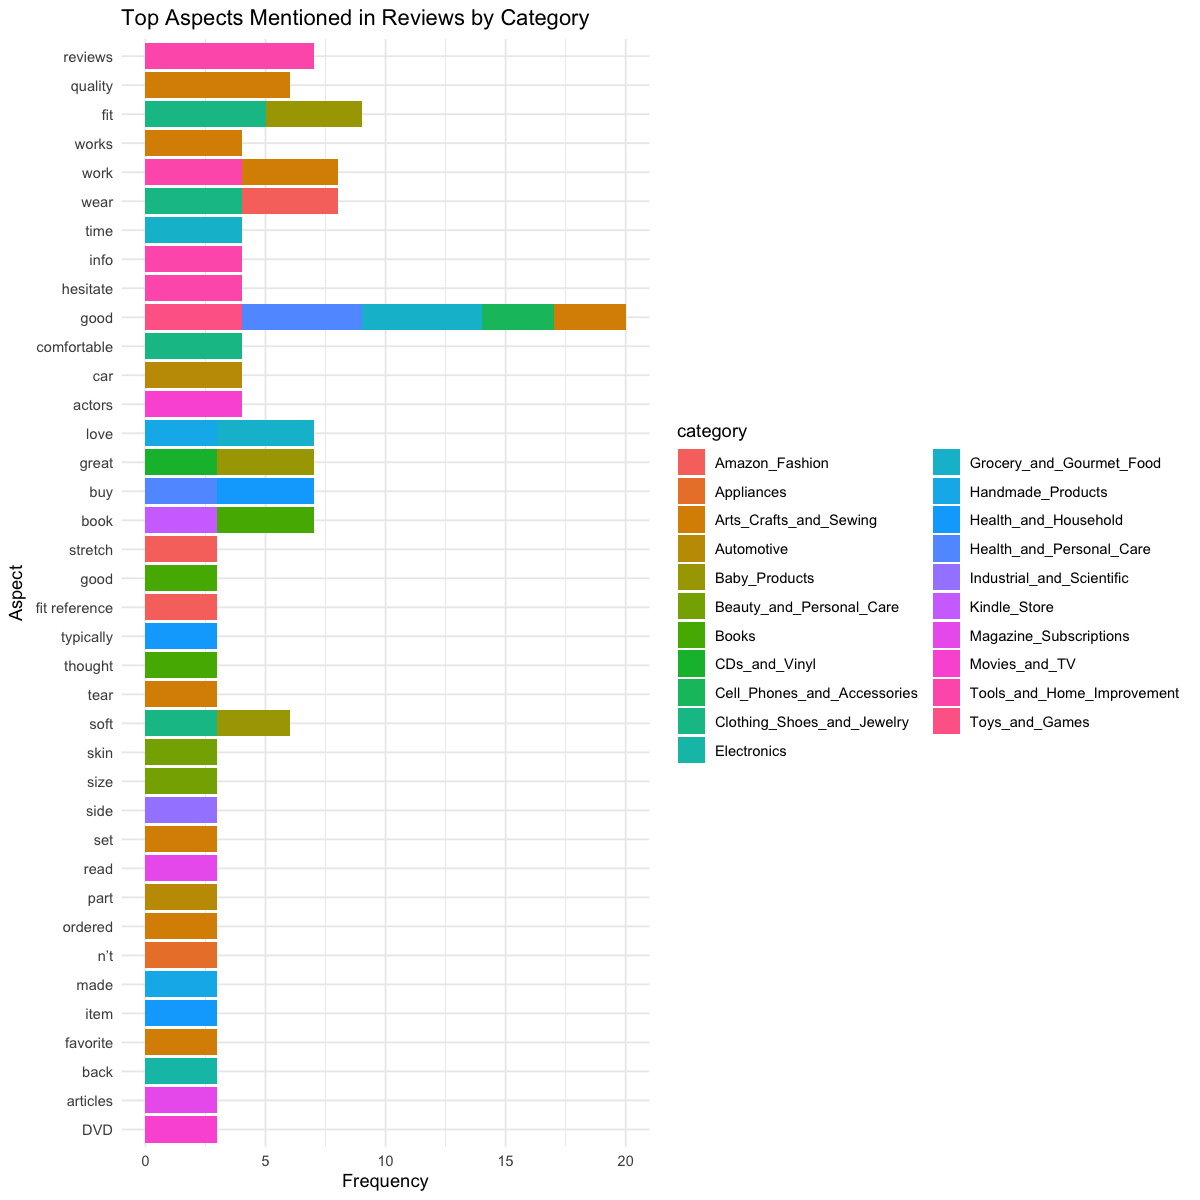

`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.


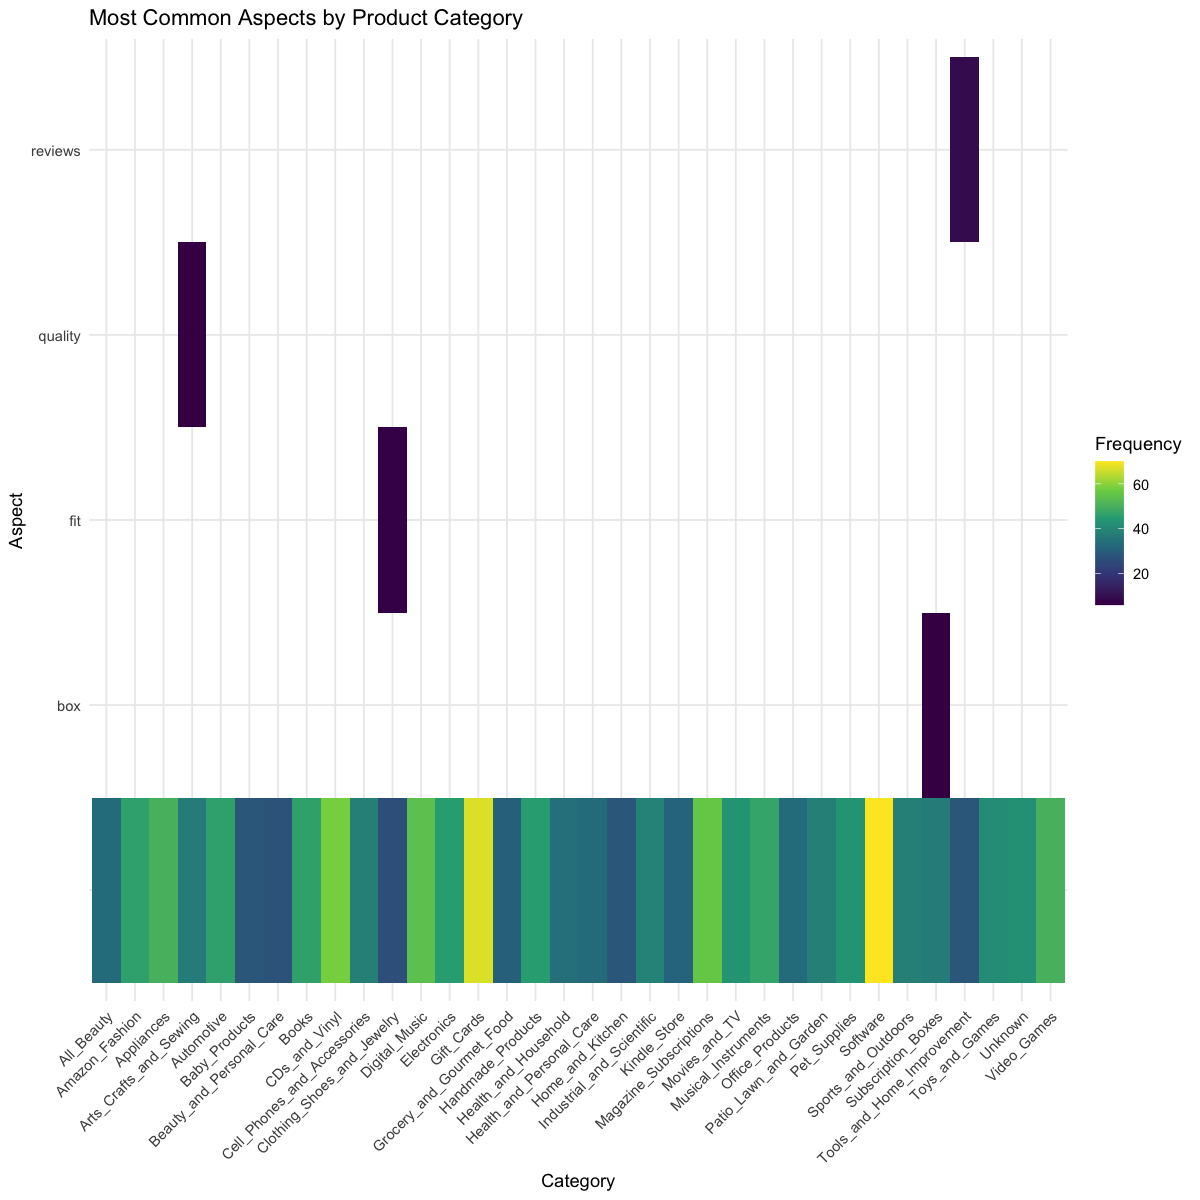

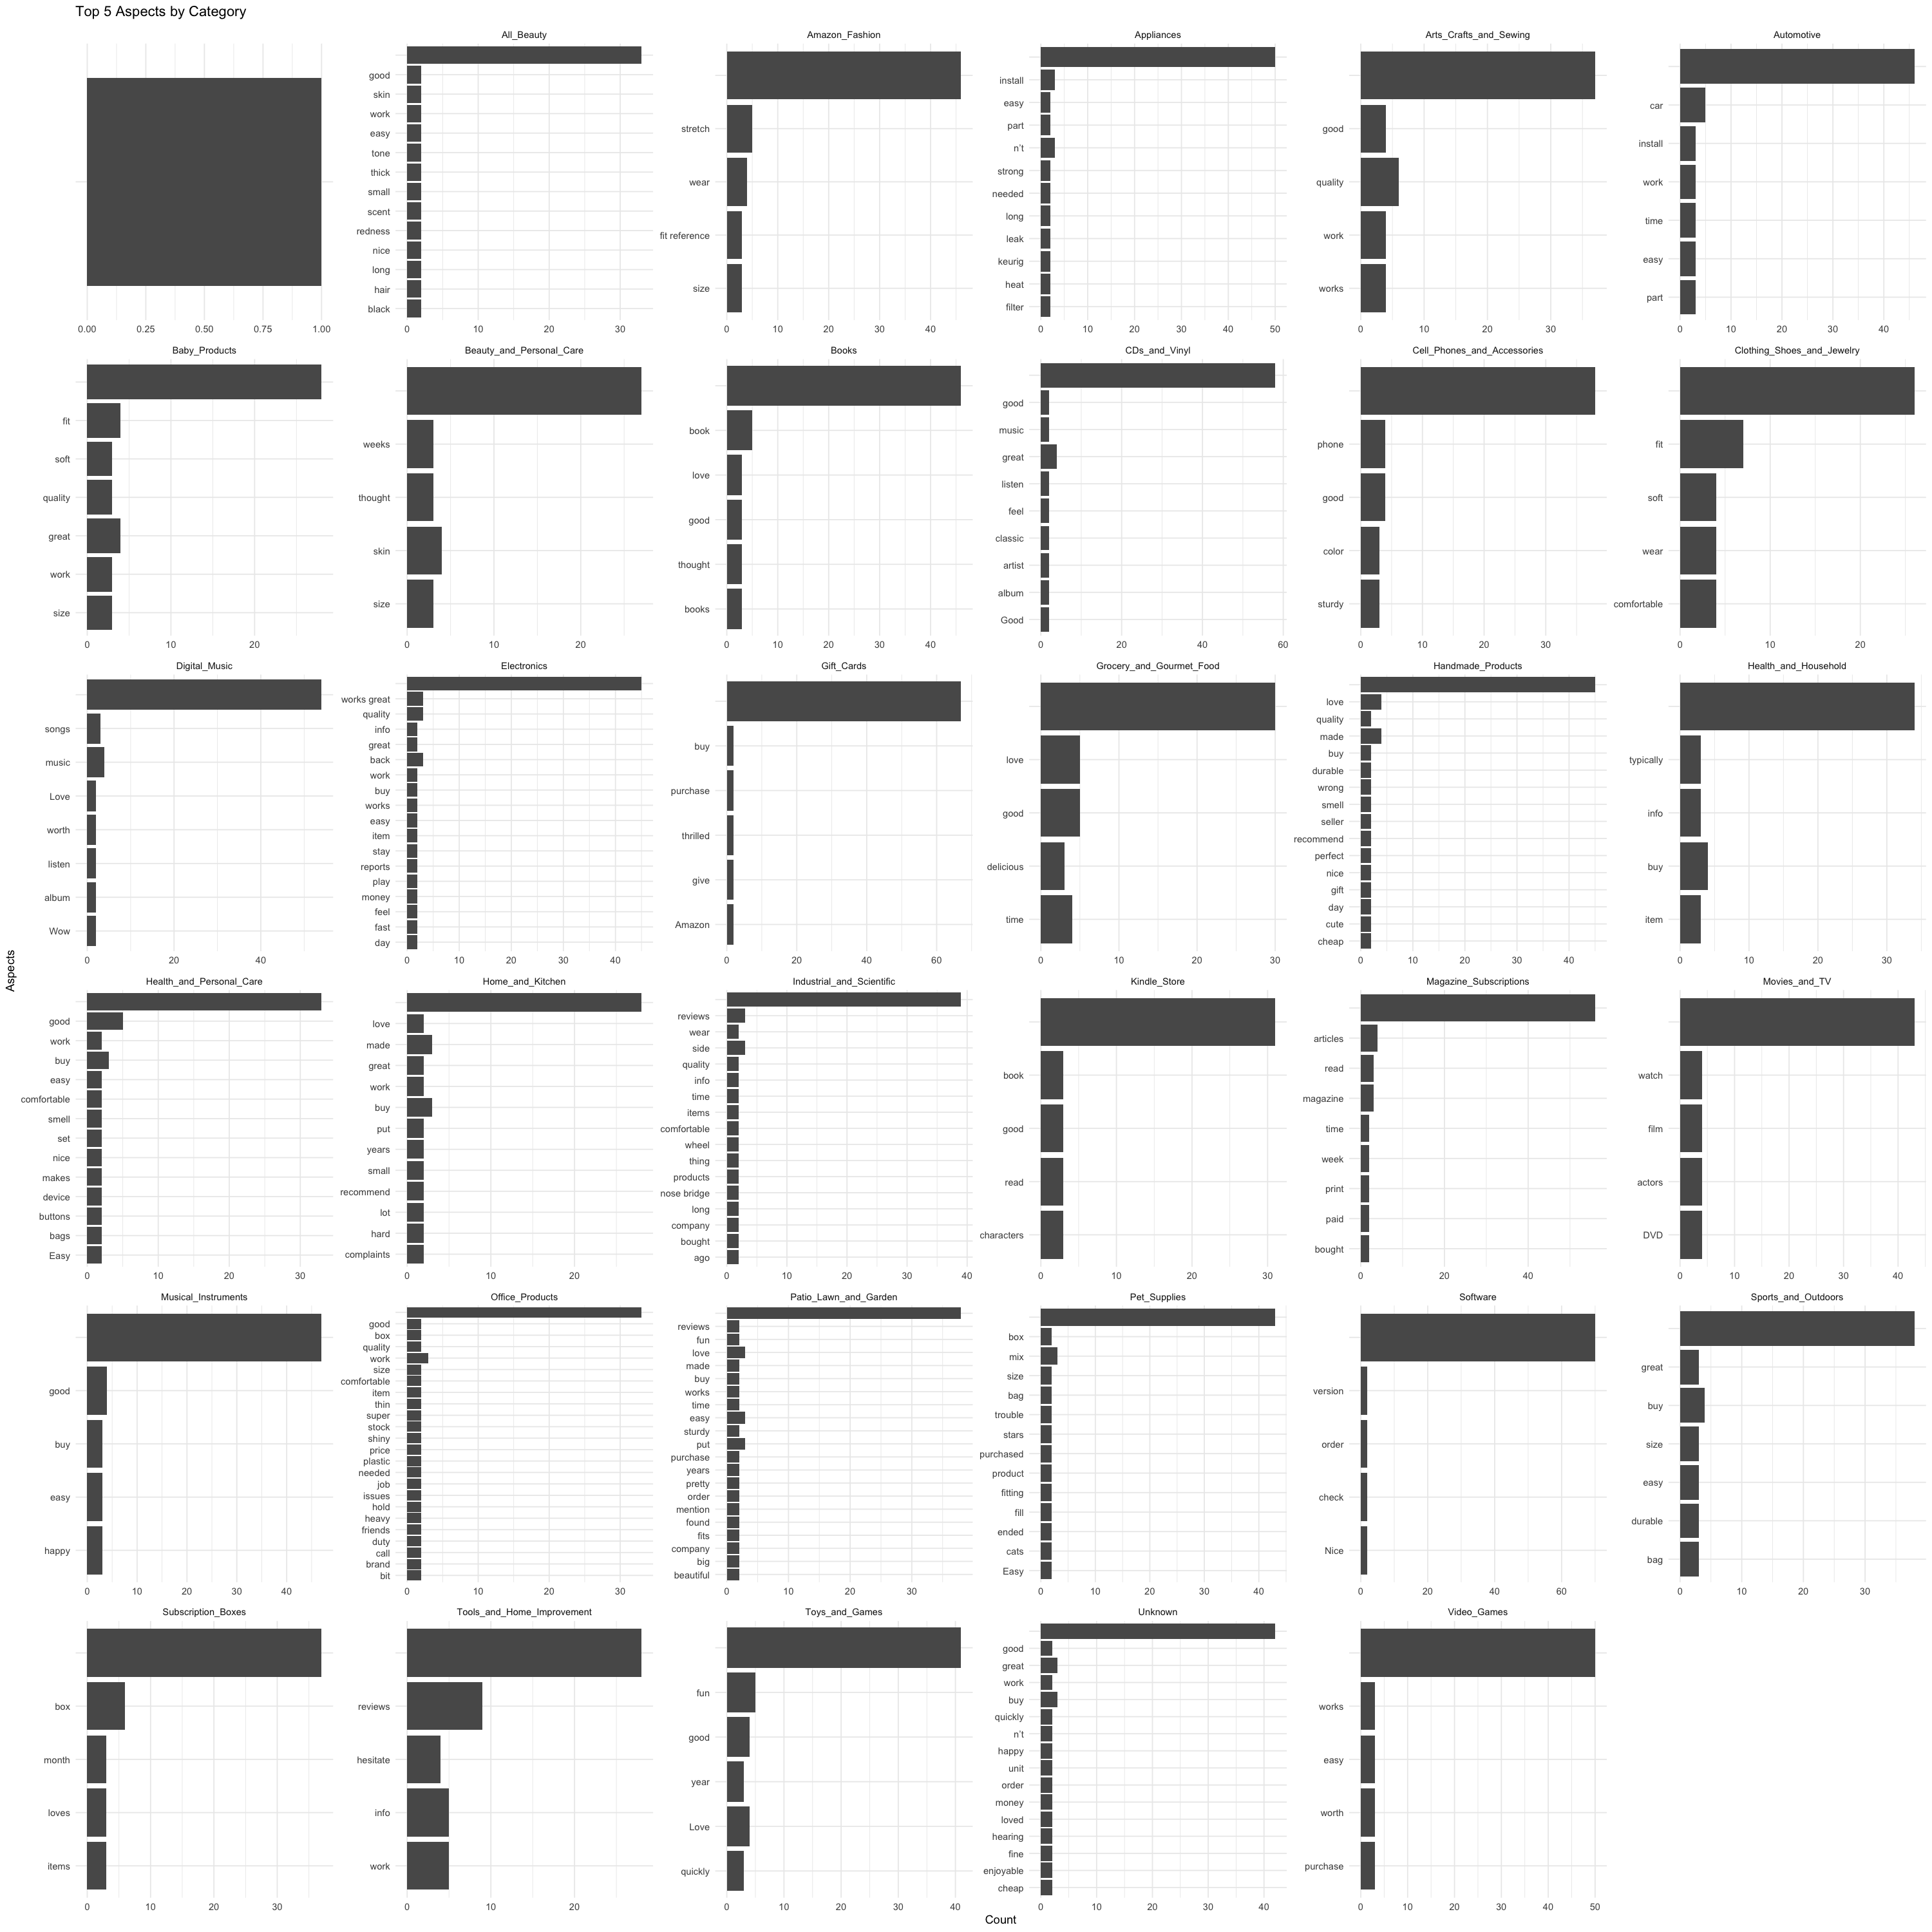

In [205]:
options(repr.plot.width=10, repr.plot.height=10)

df$aspects_clean <- gsub("\\[|\\]|\\'", "", df$aspects)
aspects_df <- df %>%
    separate_rows(aspects_clean, sep = ",") %>%
    group_by(category, aspects_clean) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    filter(aspects_clean != "")
ggplot(head(aspects_df, 50), aes(x = reorder(aspects_clean, count), y = count, fill = category)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Top Aspects Mentioned in Reviews by Category", x = "Aspect", y = "Frequency")

aspect_analysis <- df %>%
    mutate(aspects = str_remove_all(aspects, "\\[|\\]|\\'")) %>%
    separate_rows(aspects, sep = ", ") %>%
    group_by(category, aspects) %>%
    summarise(count = n()) %>%
    arrange(desc(count))
ggplot(aspect_analysis %>% filter(count > 5), aes(x = category, y = aspects, fill = count)) +
    geom_tile() +
    scale_fill_viridis_c() +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = "Most Common Aspects by Product Category", x = "Category", y = "Aspect", fill = "Frequency")

df$aspects_clean <- gsub("\\[|\\]|\\'", "", df$aspects)
aspects_df <- df %>%
    filter(aspects_clean != "") %>%
    separate_rows(aspects_clean, sep = ",") %>%
    group_by(category, aspects_clean) %>%
    summarise(count = n()) %>%
    arrange(desc(count))

options(repr.plot.width=25, repr.plot.height=25)

# ggplot(aspects_df %>% group_by(category) %>% top_n(5, count), aes(x = reorder(aspects_clean, count), y = count)) +
#     geom_bar(stat = "identity") +
#     facet_wrap(~category, scales = "free") +
#     coord_flip() +
#     theme_minimal() +
#     labs(x = "Aspects", y = "Count", title = "Top 5 Aspects Mentioned in Reviews by Category")

aspects_df <- df %>%
    mutate(aspects = str_remove_all(aspects, "\\[|\\]|\\'")) %>%
    separate_rows(aspects, sep = ", ") %>%
    count(category, aspects, sort = TRUE)
ggplot(aspects_df %>% group_by(category) %>% top_n(5, n), aes(x = reorder(aspects, n), y = n)) +
    geom_col() +
    facet_wrap(~category, scales = "free") +
    coord_flip() +
    theme_minimal() +
    labs(x = "Aspects", y = "Count", title = "Top 5 Aspects by Category")

# (RQ4) Can one predict the star rating from the review text?

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


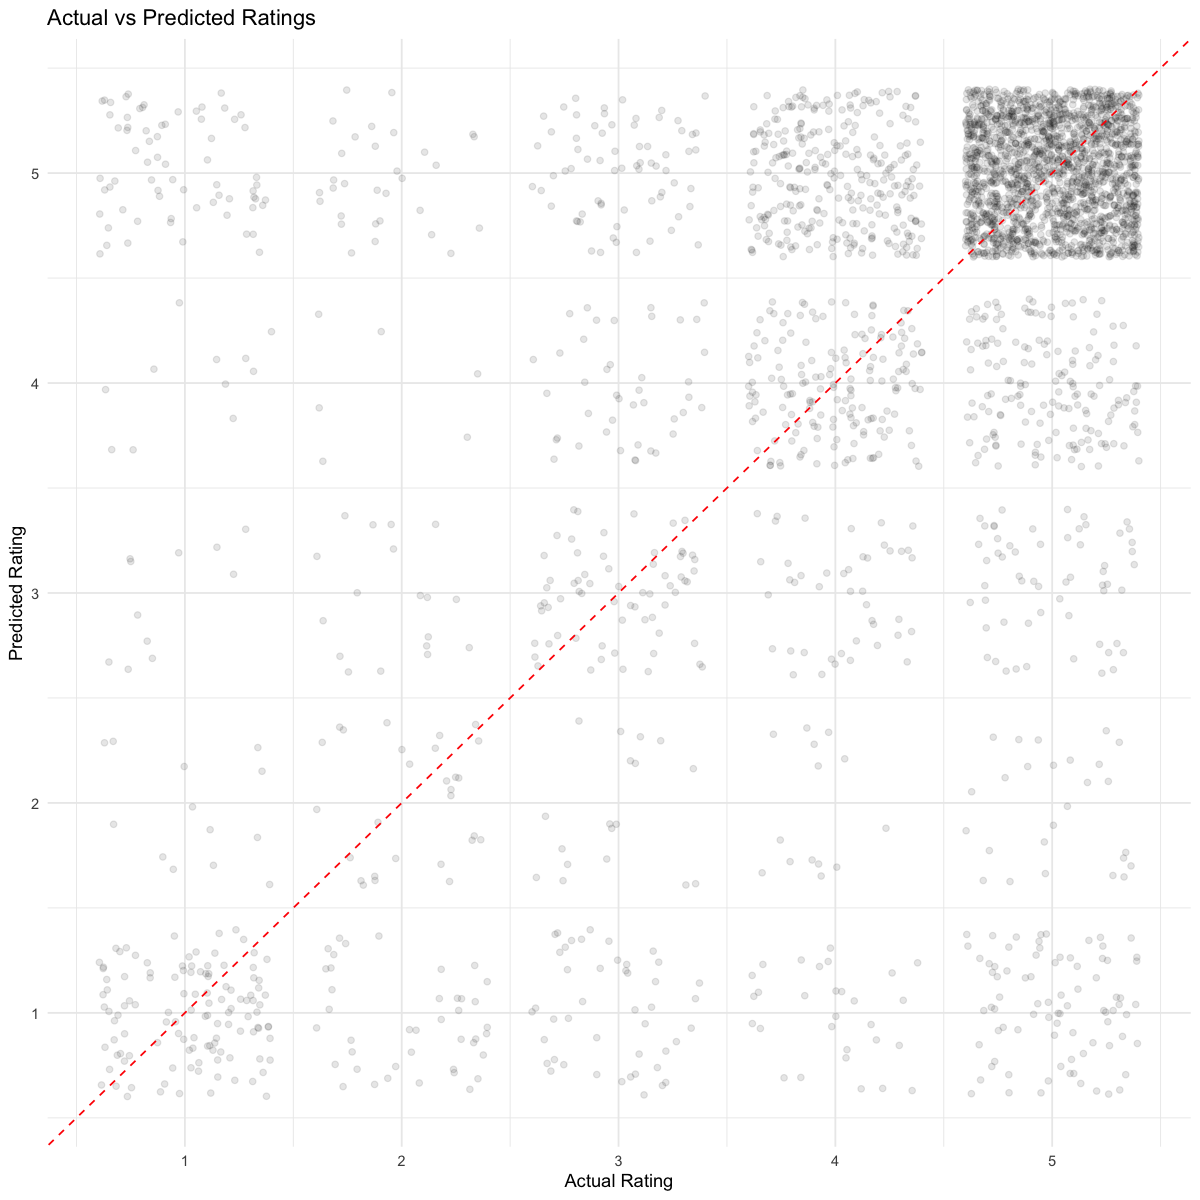

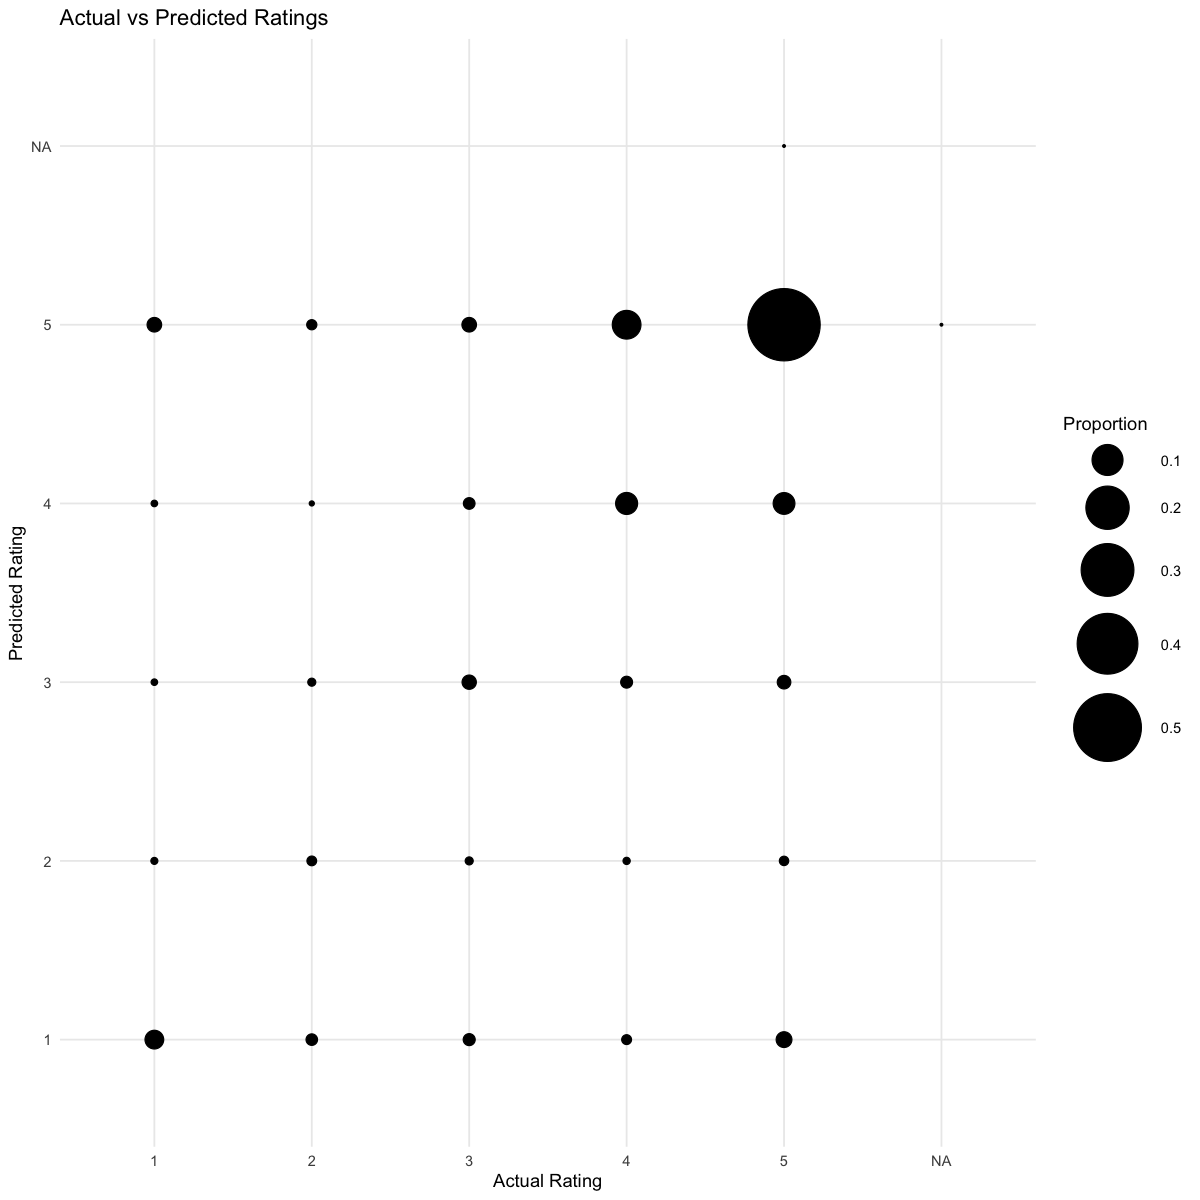

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


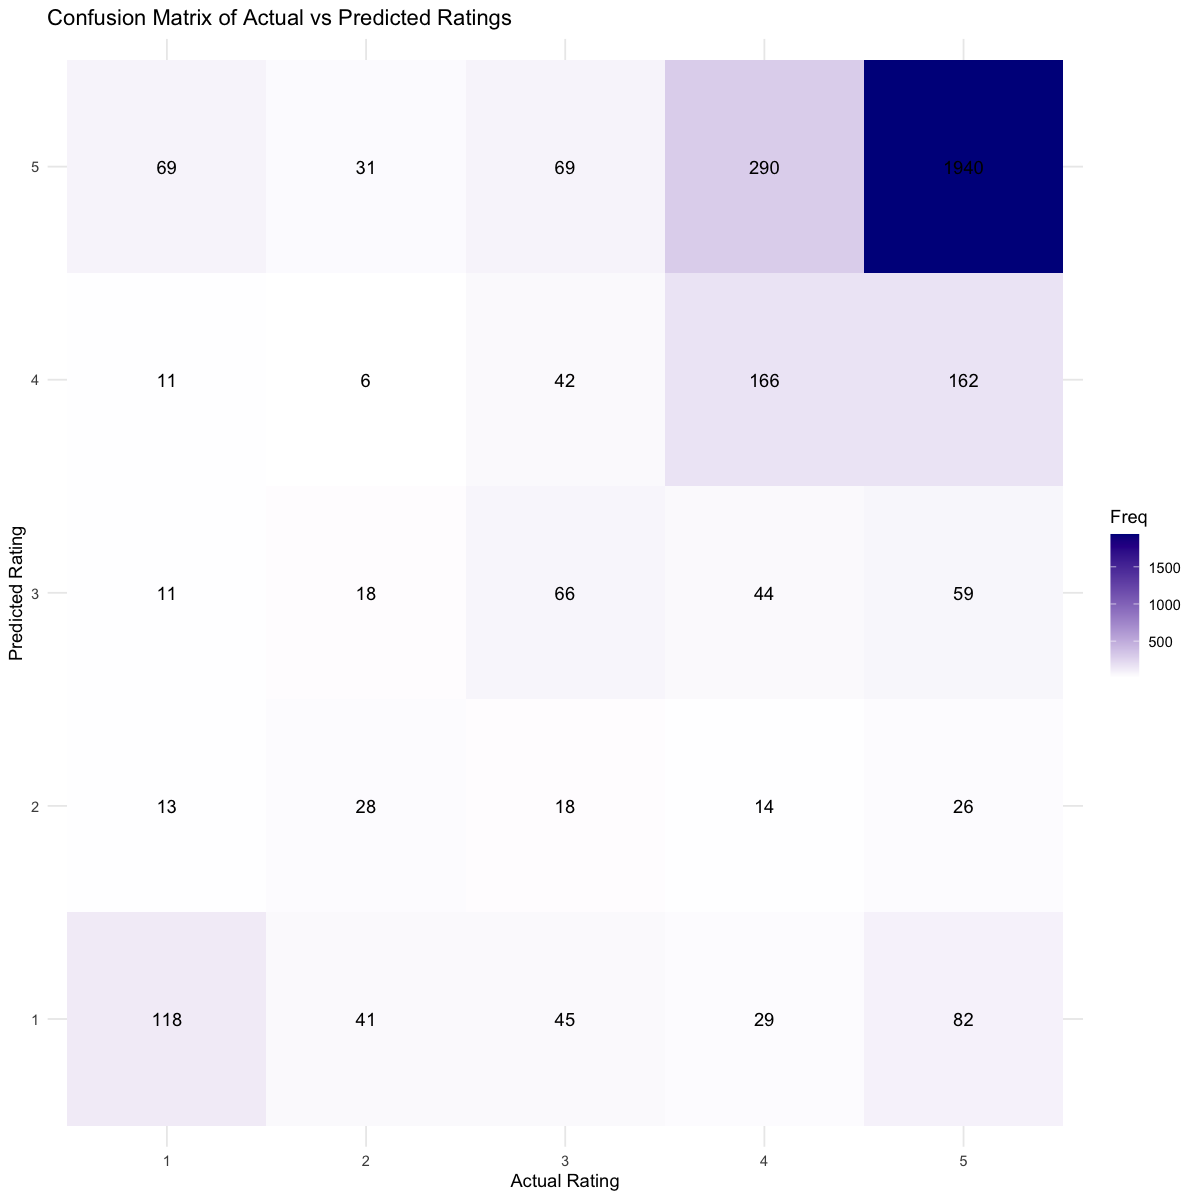

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_col()`).”


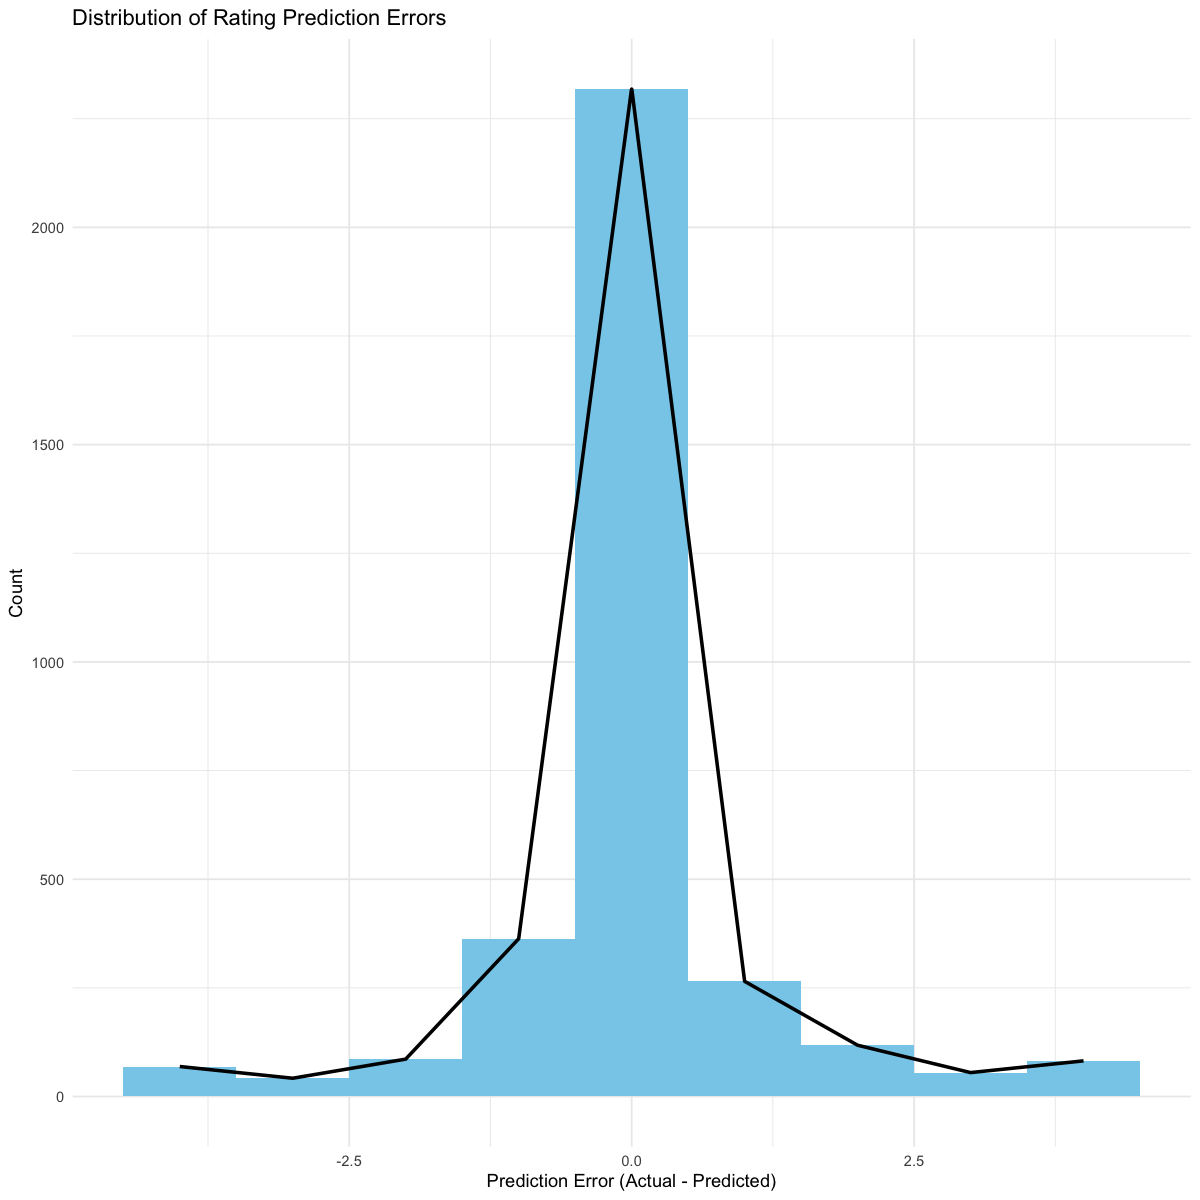

[1] "Prediction Accuracy: 68.18 %"


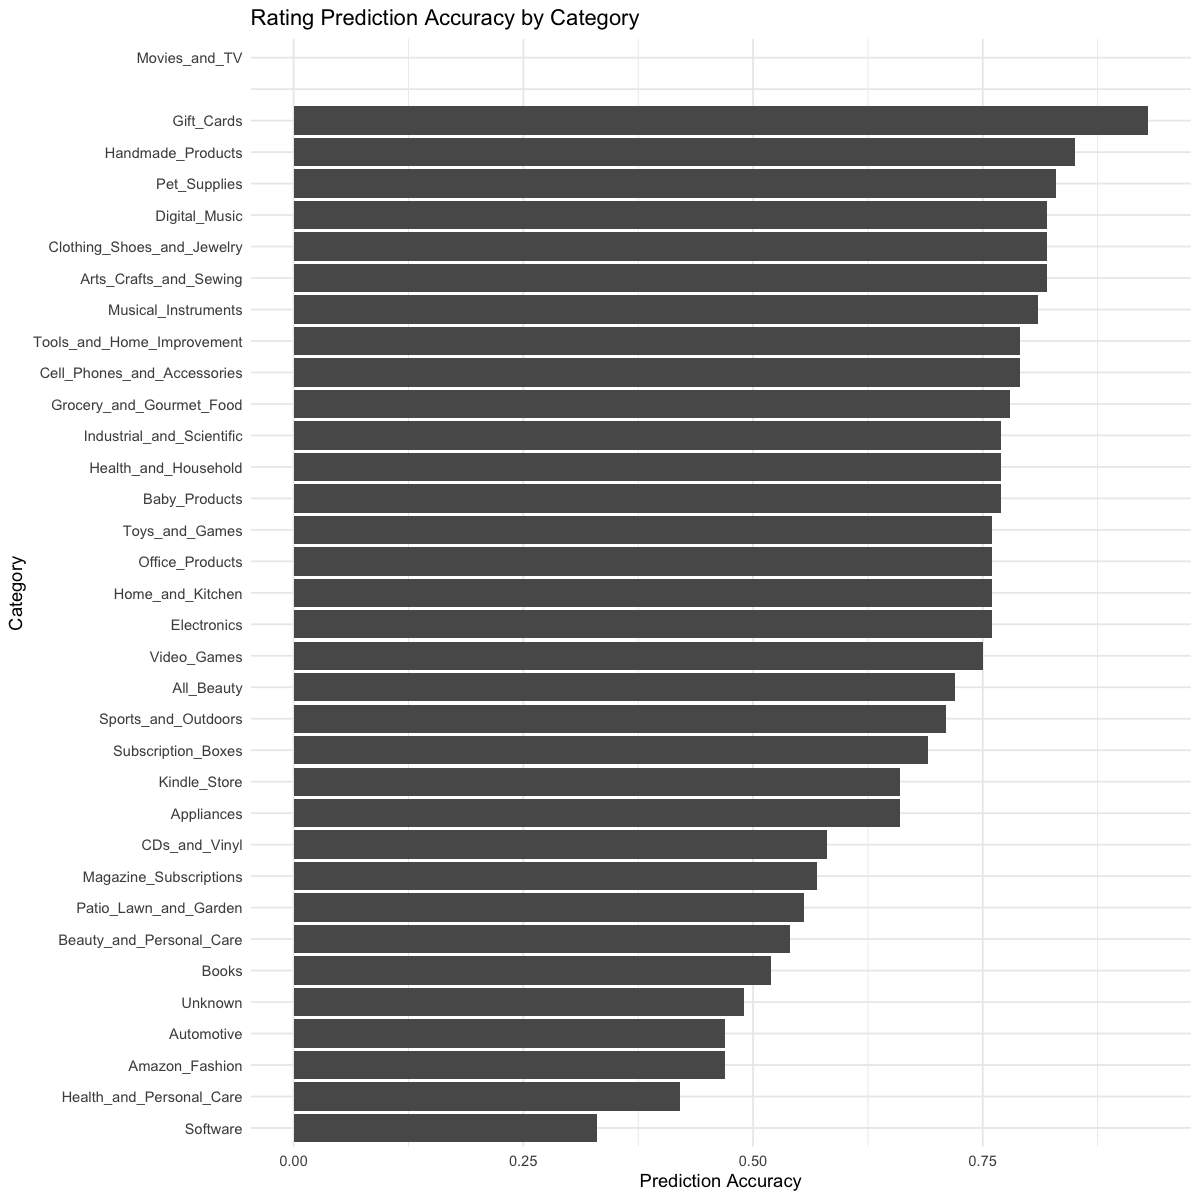

In [206]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(df, aes(x = rating, y = predicted_rating)) +
    geom_jitter(alpha = 0.1) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    labs(x = "Actual Rating", y = "Predicted Rating", title = "Actual vs Predicted Ratings") +
    theme_minimal()

ggplot(df, aes(x = factor(rating), y = factor(predicted_rating))) +
    geom_count(aes(size = after_stat(prop), group = 1)) +
    scale_size_area(max_size = 20) +
    theme_minimal() +
    labs(x = "Actual Rating", y = "Predicted Rating", title = "Actual vs Predicted Ratings", size = "Proportion")

confusion_matrix <- table(df$rating, df$predicted_rating)
ggplot(as.data.frame(confusion_matrix), aes(x = Var1, y = Var2, fill = Freq)) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "darkblue") +
    geom_text(aes(label = Freq), color = "black") +
    labs(x = "Actual Rating", y = "Predicted Rating", title = "Confusion Matrix of Actual vs Predicted Ratings") +
    theme_minimal()

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
ggplot(df, aes(x = rating - predicted_rating)) +
    geom_histogram(binwidth = 1, fill = "skyblue") +
    geom_line(stat = "count", aes(group = 1), color = "black", size = 1) +
    labs(x = "Prediction Error (Actual - Predicted)", y = "Count", title = "Distribution of Rating Prediction Errors") +
    theme_minimal()

df %>%
    group_by(category) %>%
    summarize(accuracy = mean(predicted_rating == rating)) %>%
    ggplot(aes(x = reorder(category, accuracy), y = accuracy)) +
    geom_col() +
    coord_flip() +
    theme_minimal() +
    labs(x = "Category", y = "Prediction Accuracy", title = "Rating Prediction Accuracy by Category")

accuracy <- sum(df$rating == df$predicted_rating, na.rm = TRUE) / nrow(df)
print(paste("Prediction Accuracy:", round(accuracy * 100, 2), "%"))

# data exploration

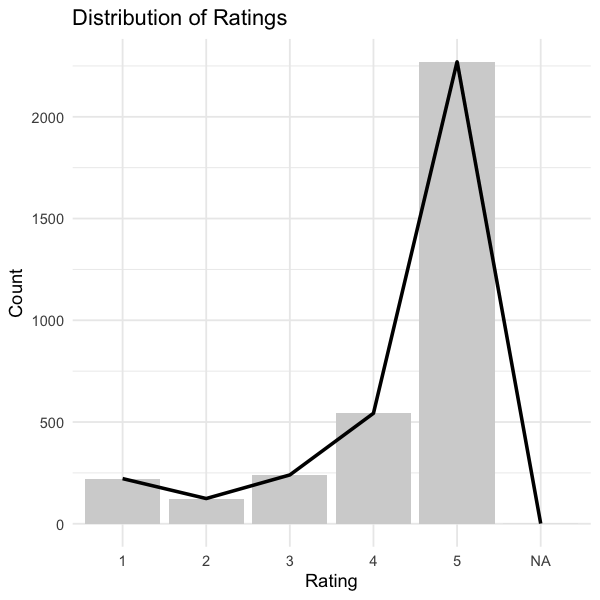

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


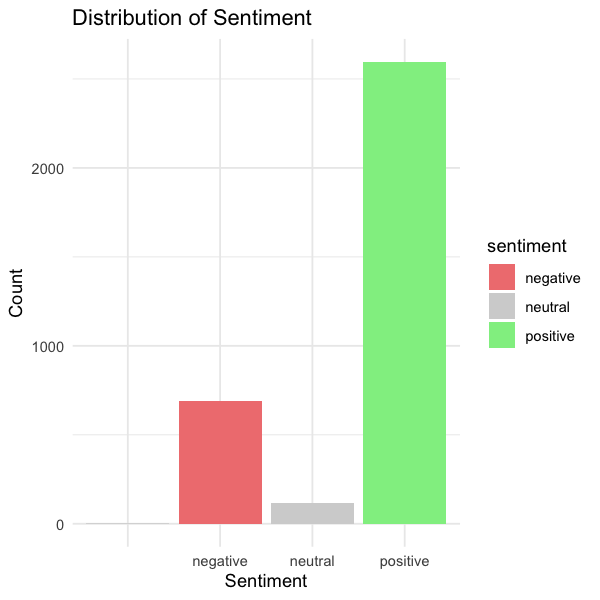

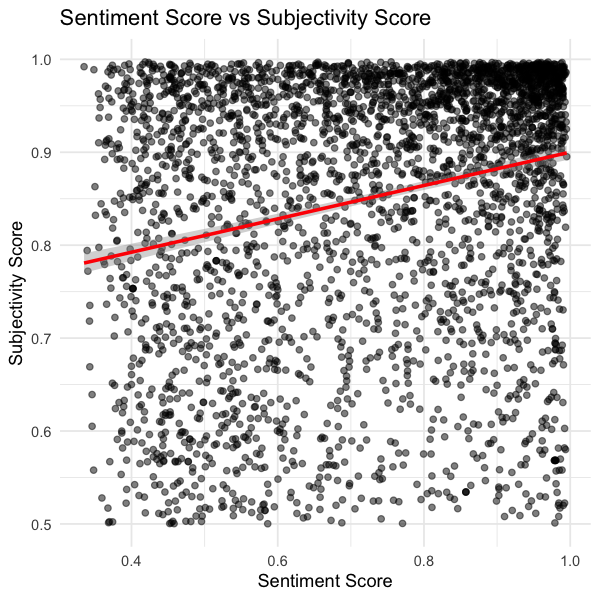

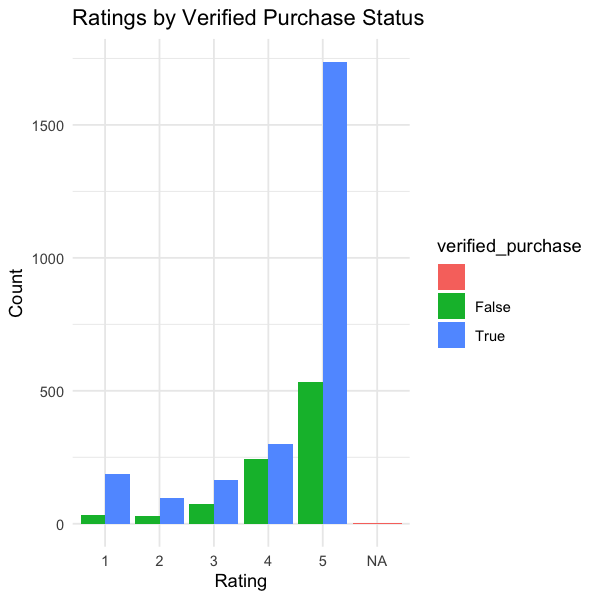

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”


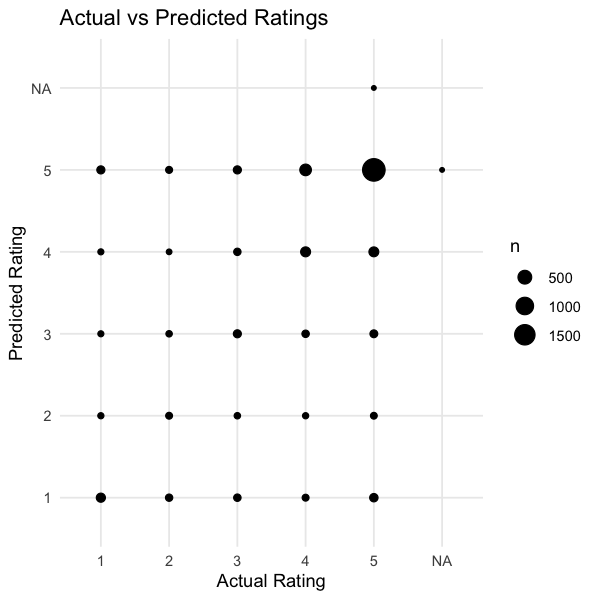

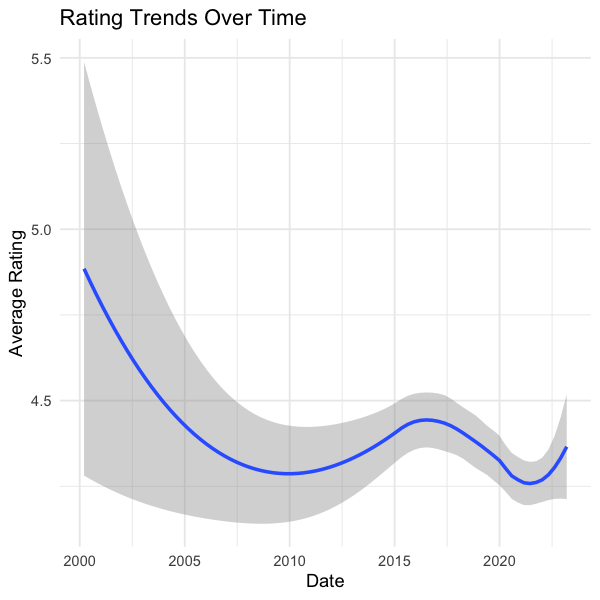

Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_ydensity()`).”


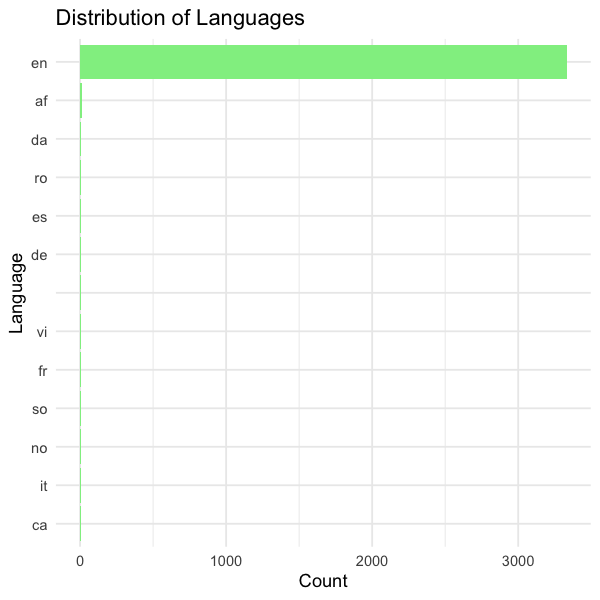

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


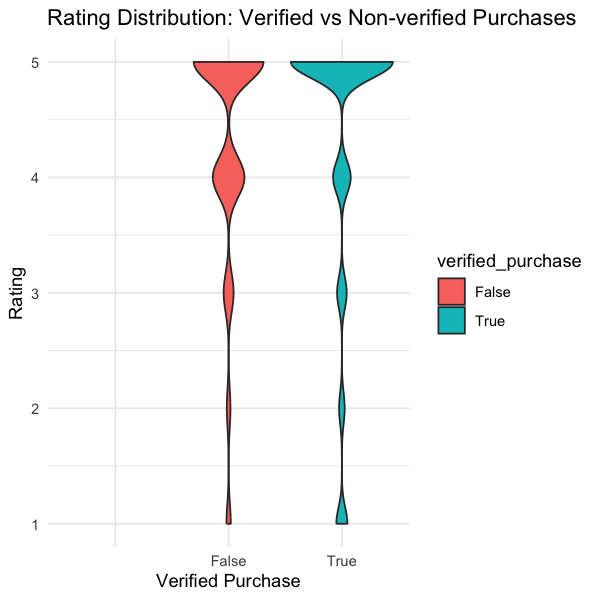

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”


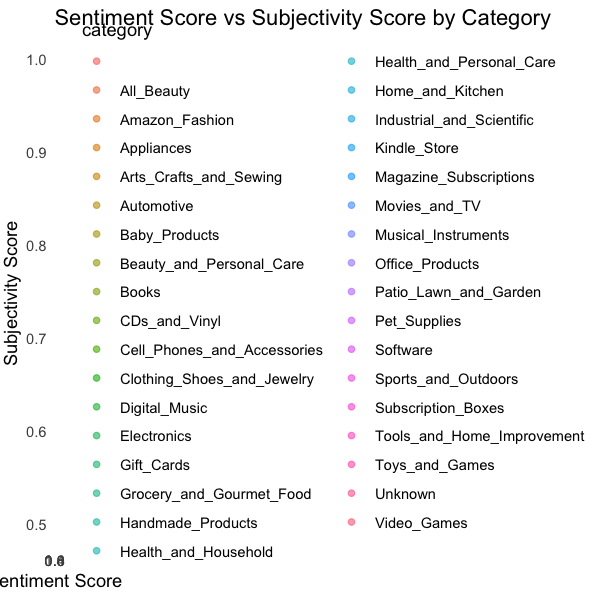

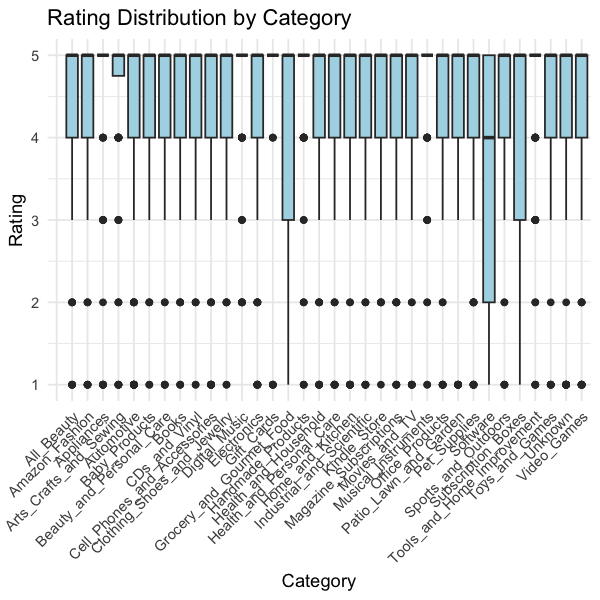

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


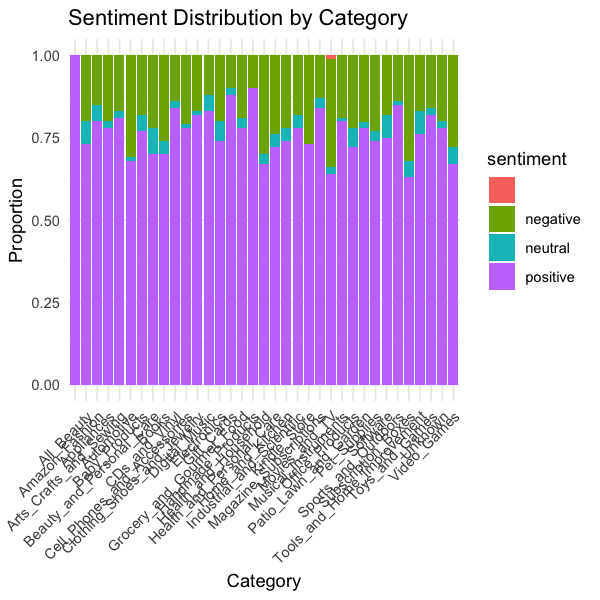

`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.


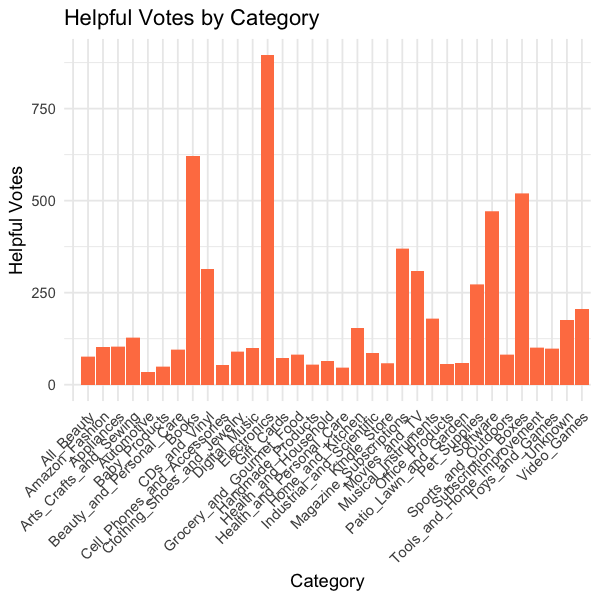

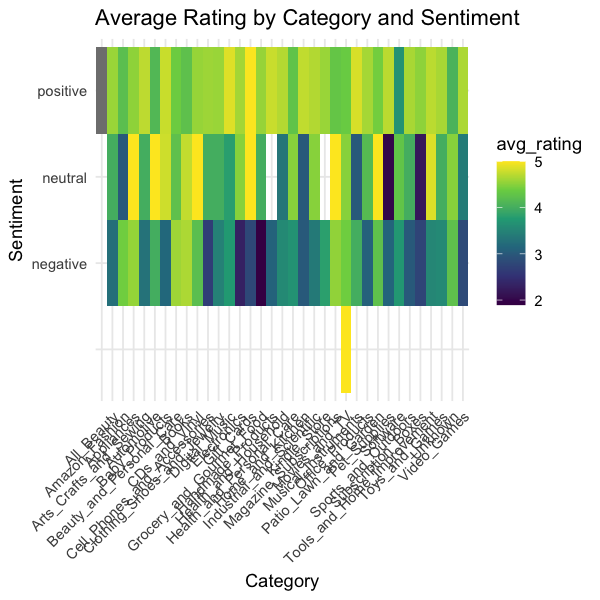

In [207]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(df, aes(x = factor(rating))) +
    geom_bar(fill = "lightgray") +
    geom_line(stat = "count", aes(group = 1), color = "black", size = 1) +
    labs(title = "Distribution of Ratings", x = "Rating", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = sentiment, fill = sentiment)) +
    geom_bar() +
    scale_fill_manual(values = c("positive" = "lightgreen", "negative" = "lightcoral", "neutral" = "lightgray")) +
    labs(title = "Distribution of Sentiment", x = "Sentiment", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = sentiment_score, y = subjectivity_score)) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", color = "red") +
    labs(title = "Sentiment Score vs Subjectivity Score", x = "Sentiment Score", y = "Subjectivity Score") +
    theme_minimal()

ggplot(df, aes(x = factor(rating), fill = verified_purchase)) +
    geom_bar(position = "dodge") +
    labs(title = "Ratings by Verified Purchase Status", x = "Rating", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = factor(rating), y = factor(predicted_rating))) +
    geom_count() +
    labs(title = "Actual vs Predicted Ratings", x = "Actual Rating", y = "Predicted Rating") +
    theme_minimal()

df %>%
    mutate(timestamp = as.Date(timestamp)) %>%
    ggplot(aes(x = timestamp, y = rating)) +
    geom_smooth(method = "loess") +
    labs(title = "Rating Trends Over Time", x = "Date", y = "Average Rating") +
    theme_minimal()

df %>%
    count(language) %>%
    top_n(10, n) %>%
    ggplot(aes(x = reorder(language, n), y = n)) +
    geom_bar(stat = "identity", fill = "lightgreen") +
    coord_flip() +
    labs(title = "Distribution of Languages", x = "Language", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = verified_purchase, y = rating, fill = verified_purchase)) +
  geom_violin() +
  theme_minimal() +
  labs(title = "Rating Distribution: Verified vs Non-verified Purchases", x = "Verified Purchase", y = "Rating")

ggplot(df, aes(x = sentiment_score, y = subjectivity_score, color = category)) +
    geom_point(alpha = 0.6) +
    theme_minimal() +
    labs(title = "Sentiment Score vs Subjectivity Score by Category", x = "Sentiment Score", y = "Subjectivity Score")

ggplot(df, aes(x = category, y = rating)) +
    geom_boxplot(fill = "lightblue") +
    theme_minimal() +
    labs(title = "Rating Distribution by Category", x = "Category", y = "Rating") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(df, aes(x = category, fill = sentiment)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = "Sentiment Distribution by Category", x = "Category", y = "Proportion")

ggplot(df, aes(x = category, y = helpful_vote)) +
    geom_bar(stat = "identity", fill = "coral") +
    theme_minimal() +
    labs(title = "Helpful Votes by Category", x = "Category", y = "Helpful Votes") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

df %>%
    group_by(category, sentiment) %>%
    summarize(avg_rating = mean(rating, na.rm = TRUE)) %>%
    ggplot(aes(x = category, y = sentiment, fill = avg_rating)) +
    geom_tile() +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_viridis_c() +
    labs(title = "Average Rating by Category and Sentiment", x = "Category", y = "Sentiment")